In [1]:
!pip install scikit-optimize

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# knn imputer
from sklearn.impute import KNNImputer

#models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# model training
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from joblib import dump, load

In [3]:
# Load the data
apartment_data = pd.read_csv('apt_eda_clean_data.csv')

In [4]:
apartment_data.head()

,amount,latitude,longitude,stratum,bathrooms,m2Terrain,bedrooms,garage
0,770000000,6.245293,-75.595479,5.0,3,117.0,3,1
1,619500000,6.230184,-75.590876,4.0,3,144.0,3,1
2,750000000,6.238153,-75.592649,5.0,2,100.0,3,1
3,763000000,6.216125,-75.608404,5.0,2,87.0,2,2
4,660000000,6.219651,-75.566952,NaN,2,90.0,3,1


In [5]:
apartment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   amount     914 non-null    int64  
 1   latitude   914 non-null    float64
 2   longitude  914 non-null    float64
 3   stratum    871 non-null    float64
 4   bathrooms  914 non-null    int64  
 5   m2Terrain  914 non-null    float64
 6   bedrooms   914 non-null    int64  
 7   garage     914 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 57.3 KB


In [6]:
# Fit datatypes for memory usage optimization
apartment_data['stratum']=apartment_data['stratum'].astype('category')
apartment_data['stratum']=apartment_data['stratum'].astype('category')
apartment_data['m2Terrain']=apartment_data['m2Terrain'].astype('float32')
apartment_data['garage']=apartment_data['garage'].astype('int8')
apartment_data['bathrooms']=apartment_data['bathrooms'].astype('int8')
apartment_data['bedrooms']=apartment_data['bedrooms'].astype('int8')

## Data preprocessors

In [7]:
df = apartment_data.copy()

# Define column types
numerical_cols = ['latitude', 'longitude', 'm2Terrain', 'bathrooms', 'bedrooms', 'garage']
categorical_cols = ['stratum']

# Create preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [8]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['latitude', 'longitude', 'm2Terrain',
                                  'bathrooms', 'bedrooms', 'garage']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(weights='distance')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['stratum'])])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   amount     914 non-null    int64   
 1   latitude   914 non-null    float64 
 2   longitude  914 non-null    float64 
 3   stratum    871 non-null    category
 4   bathrooms  914 non-null    int8    
 5   m2Terrain  914 non-null    float32 
 6   bedrooms   914 non-null    int8    
 7   garage     914 non-null    int8    
dtypes: category(1), float32(1), float64(2), int64(1), int8(3)
memory usage: 28.9 KB


# Train models

In [10]:
def get_model_metrics(y_test,y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred) * 100

  return {"mse" : mse , rmse: rmse, "r2": r2, "mae": mae, "mape": mape}

In [11]:
def build_model(regressor_fn, preprocessor,df):
  X = df.drop(columns=['amount'])
  Y = df['amount']

  x_train, x_test, y_train, y_test = train_test_split(
          X, Y, test_size=0.2, random_state=42
      )

  regressor_pipe = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('regressor', regressor_fn)
  ])
  model = regressor_pipe.fit(x_train, y_train)

  y_pred = model.predict(x_test)
  y_pred_train = model.predict(x_train)

  model_metrics_test = get_model_metrics(y_test, y_pred)
  model_metrics_train = get_model_metrics(y_train,y_pred_train)

  return {"train": model_metrics_train, "test": model_metrics_test}

In [12]:
models = {
     "Linear Regression": LinearRegression(),
      "Random Forest Regressor": RandomForestRegressor(random_state=42),
      "XGBoost Regressor": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
}

In [13]:
result_dict = {}

for model_name, model in models.items():
    result_dict[model_name] = build_model(model, preprocessor, df)

In [14]:
result_dict

{'Linear Regression': {'train': {'mse': 3.968521235631052e+16,
   np.float64(199211476.46737254): np.float64(199211476.46737254),
   'r2': 0.7192869363948384,
   'mae': 133829722.2100579,
   'mape': 21.524083136544505},
  'test': {'mse': 2.3656731928912148e+16,
   np.float64(153807450.8237886): np.float64(153807450.8237886),
   'r2': 0.7692217742642419,
   'mae': 119408667.02115598,
   'mape': 20.836531897998736}},
 'Random Forest Regressor': {'train': {'mse': 5542497002738629.0,
   np.float64(74447948.27756256): np.float64(74447948.27756256),
   'r2': 0.9607951873939315,
   'mae': 47270895.65071243,
   'mape': 6.646832612024936},
  'test': {'mse': 2.272463911106024e+16,
   np.float64(150746937.31900573): np.float64(150746937.31900573),
   'r2': 0.778314607854752,
   'mae': 107138497.8313993,
   'mape': 16.38327530389652}},
 'XGBoost Regressor': {'train': {'mse': 133198319190016.0,
   np.float64(11541157.619147915): np.float64(11541157.619147915),
   'r2': 0.9990578293800354,
   'mae':

In [15]:
def plot_mape_comparison(results_dict):
    """
    Plot MAPE comparison for regression models with side-by-side bar chart.

    Parameters:
    results_dict: Dictionary containing model results with train/test MAPE values
    """
    # Extract model names and MAPE values
    models = list(results_dict.keys())
    train_mape = [results_dict[model]['train']['mape'] for model in models]
    test_mape = [results_dict[model]['test']['mape'] for model in models]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set up bar positions
    x = np.arange(len(models))
    width = 0.35

    # Create bars
    ax.bar(x - width/2, train_mape, width, label='Train', color='skyblue')
    ax.bar(x + width/2, test_mape, width, label='Test', color='salmon')

    # Customize plot
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_title('MAPE Comparison: Train vs Test')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

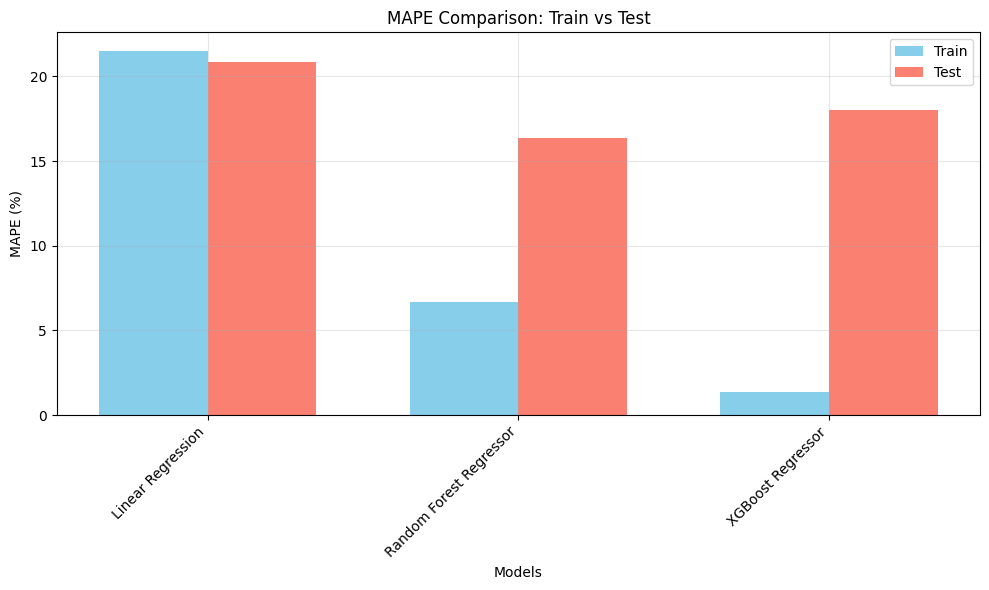

In [16]:
plot_mape_comparison(result_dict)

## Cross-validation

In [17]:
def cross_validation(df,preprocessor,models,scoring_metrics):
  X = df.drop(columns=['amount'])
  Y = df['amount']

  x_train, x_test, y_train, y_test = train_test_split(
          X, Y, test_size=0.2, random_state=42
      )

  fold = KFold(n_splits=5, shuffle=True, random_state=42)

  # Variable to store the results of the cross-validation
  cv_results = {metric: {} for metric in scoring_metrics}

  for model_name, model in models.items():
      regressor_pipe = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('regressor', model)
      ])
      for metric in scoring_metrics:
        cv_results[metric][model_name] = cross_val_score(
            regressor_pipe, x_train, y_train, cv=fold, scoring=metric
        )

  # Convert results into a pandas DataFrame for each metric
  cv_results_df = {metric: pd.DataFrame(cv_results[metric]) for metric in scoring_metrics}

  return cv_results_df

In [18]:
models = {
     "Random Forest Regressor": RandomForestRegressor(random_state=42),
      "XGBoost Regressor": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
}

# Evaluation metrics
scoring_metrics = ["r2", "neg_mean_absolute_percentage_error"]

cv_results_df = cross_validation(df,preprocessor,models,scoring_metrics)

In [19]:
# Create a DataFrame to store mean and std for each metric and model
mean_std_data = []

for metric_name in scoring_metrics:
    for model_name in models:
        mean_score = cv_results_df[metric_name][model_name].mean()
        std_score = cv_results_df[metric_name][model_name].std()
        mean_std_data.append(
            {
                "Model": model_name,
                "Metric": metric_name,
                "Mean": mean_score,
                "Std": std_score,
            }
        )

mean_std_df = pd.DataFrame(mean_std_data)

mean_std_df

,Model,Metric,Mean,Std
0,Random Forest Regressor,r2,0.717180,0.076834
1,XGBoost Regressor,r2,0.695852,0.077878
2,Random Forest Regressor,neg_mean_absolute_percentage_error,-0.186916,0.012869
3,XGBoost Regressor,neg_mean_absolute_percentage_error,-0.182248,0.012577


## Hyperparameter tuning

In [20]:
X = df.drop(columns=['amount'])
Y = df['amount']

x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

score = "neg_mean_absolute_percentage_error"

### Random Forest

In [21]:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)


regression_pipe = Pipeline(
    steps = [
        ("preprocessor",preprocessor),
        ("model", rf_model)
    ]
)

grid_search = GridSearchCV(regression_pipe, param_grid, cv=5, scoring=score, return_train_score=True, verbose=1)

# Fit the grid search
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'm2Terrain',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'garage']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(weights='distance')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['stratum'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [50, 100, 200]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [22]:
rf_final_pipe = Pipeline(
    steps = [
        ("preprocessor",preprocessor),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
    ]
)

rf_final_pipe.set_params(**grid_search.best_params_)

rf_final_model = rf_final_pipe.fit(x_train, y_train)

y_pred = rf_final_model.predict(x_test)

get_model_metrics(y_test, y_pred)

{'mse': 2.2351525844373476e+16,
 np.float64(149504266.97714508): np.float64(149504266.97714508),
 'r2': 0.7819544351116695,
 'mae': 102636865.94496357,
 'mape': 15.818790928707582}

### XGBoost Regressor

In [22]:
param_grid_xgbr = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 4, 5, 6],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.1, 1],  # L1 regularization
        'model__reg_lambda': [1, 1.5, 2]  # L2 regularization
    }

xgb_reg_model = xgb.XGBRegressor(
        random_state=42,
        n_jobs=-1,
        verbosity=1
    )

regression_pipe_xgb = Pipeline(
    steps = [
        ("preprocessor",preprocessor),
        ("model", xgb_reg_model)
    ]
)

grid_search_xgbr = GridSearchCV(regression_pipe_xgb, param_grid_xgbr, cv=5, scoring=score, return_train_score=True, verbose=1)

# Fit the grid search
grid_search_xgbr.fit(x_train, y_train)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'm2Terrain',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'garage']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(weights='distance')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['stratum'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,...
                                                     random_state=42, ...))]),
             param_grid={'model__colsample_bytree': [0.8, 0.9, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5, 6],
                         'model__n_estimators': [100, 200, 300],
                         'model__reg_alpha': [0, 0.1, 1],
                         'model__reg_lambda': [1, 1.5, 2],
                         'model__subsample': [0.8, 0.9, 1.0]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [25]:
xgbr_final_pipe = Pipeline(
    steps = [
        ("preprocessor",preprocessor),
        ("model", xgb.XGBRegressor())
    ]
)

xgbr_final_pipe.set_params(**grid_search_xgbr.best_params_)

xgbr_final_model = xgbr_final_pipe.fit(x_train, y_train)

y_pred_xgbr = xgbr_final_model.predict(x_test)

get_model_metrics(y_test, y_pred_xgbr)

{'mse': 2.514212866542797e+16,
 np.float64(158562696.32365605): np.float64(158562696.32365605),
 'r2': 0.754731297492981,
 'mae': 105221416.0,
 'mape': 16.38832986354828}

After hyperparameter tuning, I picked RandomForestRegressor model since it has a better R2 metric and MAPE.

## Prediction test

In [23]:
new_apartment_listing = pd.DataFrame({
    'latitude': [6.1806032839999],       # Example latitude for a single new apartment
    'longitude': [-75.572539211115],    # Example longitude
    'stratum': [6],             # Example stratum
    'bathrooms': [2],           # Example number of bathrooms
    'm2Terrain': [100],         # Example square meters
    'bedrooms': [2],            # Example number of bedrooms
    'garage': [2]               # Example number of garage spots
})

In [24]:
new_apartment_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   1 non-null      float64
 1   longitude  1 non-null      float64
 2   stratum    1 non-null      int64  
 3   bathrooms  1 non-null      int64  
 4   m2Terrain  1 non-null      int64  
 5   bedrooms   1 non-null      int64  
 6   garage     1 non-null      int64  
dtypes: float64(2), int64(5)
memory usage: 188.0 bytes


In [25]:
predicted_price = rf_final_model.predict(new_apartment_listing)

In [26]:
print(f"Predicted Price for the New Apartment: ${predicted_price[0]:.2f}")

Predicted Price for the New Apartment: $956275101.51


## Save and test model

In [30]:
dump(rf_final_model, r"models/rf-model.joblib")

['models/rf-model.joblib']

In [31]:
my_model = load(r"models/rf-model.joblib")

In [32]:
my_model.predict(new_apartment_listing)

array([9.56275102e+08])